# **Latent Dirichlet Allocation**


## **Preparación**


In [36]:
import pandas as pd

scopus = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/scopus-abstracts.csv")
df=scopus[['Abstract']]
df['original']=scopus[['Abstract']]

## **Descripción del problema**


Uno de los principales problemas abordados en minería de texto consiste en la extracción de los temas o tópicos a los que pertenece documento. Por ejemplo, una noticia podría pertener simultáneamente a los temas de religión y economía (el escándalo por el manejo de fondos del Vaticano). Cuando se tiene un conjunto de documentos, se desea extraer los tópicos subyacentes sobre los que tratan los documentos.

Scikit-learn contiene una implementación de la metodología Latent Dirichlet Allocation, la cual permite extraer los tópicos de un conjunto de documentos. Véase https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

Utilice esta metodología para extraer los tópicos subyacentes en los abstracts de los artículos. Tenga en cuenta que:

1. Debe establecer como obtener el número apropiado de tópicos a obtener.

2. Debe eliminar las stop-words.

3. En T-Lab sugieren reducir las palabras a sustantivos, adjetivos, verbos y adverbios únicamente. Cómo podría realizar esto en su código=?

4. Cómo podría verificar si la cantidad de temas es apropiada desde el punto de vista de su contenido (las palabras que contiene y los temas que trata)?


## **Desarrollo**

Inicialmente cargamos todas las librerias que se van a utilizar para el modelado de tópicos.

In [2]:
#!pip install update sklearn
#!pip install pyLDAvis

import numpy as np
import pandas as pd
import re
import nltk
import spacy
import gensim
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import gensim
import gensim.corpora as corpora
#import pyLDAvis
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
from spacy import displacy

from spacy.lang.en.stop_words import STOP_WORDS

# init
warnings.filterwarnings("ignore")
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Realizamos una breve vista al documento, con el fin de identificar su estructura

In [3]:
df.head()

,Abstract,original
0,Mobility is one of the fundamental requirement...,Mobility is one of the fundamental requirement...
1,The recent rise of the political extremism in ...,The recent rise of the political extremism in ...
2,The power of the press to shape the informatio...,The power of the press to shape the informatio...
3,Identifying influential nodes in a network is ...,Identifying influential nodes in a network is ...
4,"To complement traditional dietary surveys, whi...","To complement traditional dietary surveys, whi..."


### **Limpieza de datos**

La limpieza de datos es primoridal en aplicaciones de lenguaje natural, es realizada con el fin de obtener los mejores insumos al modelo de datos. Se obtienen datos sin caracteres especiales, espacios en blanco inecesarios y se unen para obtener un parrafo. 

In [4]:
df['Abstract']=df['Abstract'].str.lower()
datos = df.Abstract.values.tolist()

# Remove new line characters
datos = [re.sub(r'\s+', ' ', sent) for sent in datos]

# Remove distracting single quotes
datos = [re.sub(r"\'", "", sent) for sent in datos]

# Remove unuseful charachters
datos = [re.sub('[^a-zA-Z0-9 \n]', '', sent) for sent in datos]

#join each line
datos=[" ".join(sent.split()) for sent in datos]

#a brief view of first row
df['Abstract']=datos
df['Abstract']

0       mobility is one of the fundamental requirement...
1       the recent rise of the political extremism in ...
2       the power of the press to shape the informatio...
3       identifying influential nodes in a network is ...
4       to complement traditional dietary surveys whic...
                              ...                        
1897    in this article we intend to show how useful e...
1898    in recent geographical information science lit...
1899    the fact that many decisions need a combinatio...
1900    the report from woolmark business intelligence...
1901    changing consumer lifestyles and increased tim...
Name: Abstract, Length: 1902, dtype: object

### **Tokenización y Lematización**

Iniciamos con el proceso de tokenización de la data, el cual es básicamente convertir los parrafos en una lista de palabras, en este punto se toman en cuenta todas las palabras sin realizar una distinción por stop-words. 

In [5]:
def sent_to_words(sentences):
  for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words1 = list(sent_to_words(df['Abstract']))  #datos tokenizados
print(data_words1[:1])

[['mobility', 'is', 'one', 'of', 'the', 'fundamental', 'requirements', 'of', 'human', 'life', 'with', 'significant', 'societal', 'impacts', 'including', 'productivity', 'economy', 'social', 'wellbeing', 'adaptation', 'to', 'changing', 'climate', 'and', 'so', 'on', 'although', 'human', 'movements', 'follow', 'specific', 'patterns', 'during', 'normal', 'periods', 'there', 'are', 'limited', 'studies', 'on', 'how', 'such', 'patterns', 'change', 'due', 'to', 'extreme', 'events', 'to', 'quantify', 'the', 'impacts', 'of', 'an', 'extreme', 'event', 'to', 'human', 'movements', 'we', 'introduce', 'the', 'concept', 'of', 'mobility', 'resilience', 'which', 'is', 'defined', 'as', 'the', 'ability', 'of', 'mobility', 'system', 'to', 'manage', 'shocks', 'and', 'return', 'to', 'steady', 'state', 'in', 'response', 'to', 'an', 'extreme', 'event', 'we', 'present', 'method', 'to', 'detect', 'extreme', 'events', 'from', 'geolocated', 'movement', 'data', 'and', 'to', 'measure', 'mobility', 'resilience', 'and

Miramos cuales son las palabras más frecuentes

In [6]:
full_list = []  # list containing all words of all texts
for elmnt in data_words1:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list



prueba = pd.Series(full_list)
prueba = prueba.str.strip()
prueba= prueba.str.replace(" ","_")



val_counts = prueba.value_counts()[:100].sort_values(ascending=False) # make temporary Series to count
val_counts=val_counts.to_frame()
val_counts = val_counts.set_axis(['Frequency'], axis=1, inplace=False)
val_counts.reset_index(level=0, inplace=True)
val_counts = val_counts.rename(columns={'index': 'Word'})
val_counts[:20]

,Word,Frequency
0,the,19974
1,of,12990
2,and,10928
3,to,8064
4,in,6627
5,data,4952
6,is,4128
7,for,3769
8,that,3016
9,this,2822


La lematización permite excluir palabras que no aportan al entendimiento de los tópicos y al contario genera material basura que podría interferir en un correcto resultado. Además logra filtrar por categoria de palabras y llevarlas a su "lema", permitiendo que todas las variantes de estas sean focalizadas en su lema, y asi trabajar con una lista de palabras con significado único. 

In [7]:
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

In [8]:
def clean_caracteres(arg1): 
    return re.sub('[^a-zA-Z0-9 \n]', '', arg1)

def remove_several_whitespaces(input):
    return " ".join(input.split())

def tokenize_without_stopwords(arg1):
    return ' '.join([word for word in nltk.word_tokenize(arg1) if word not in stopwords.words('english')])

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def own_lemmatize(arg1):
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(arg1)])

def remove_single_quotes(arg1):
    return re.sub(r"\'", "", arg1)

lemmatizer = WordNetLemmatizer()

df['Abstract'] = df['Abstract'].str.lower()
df['Abstract'] = df['Abstract'].apply(clean_caracteres)
df['Abstract'] = df['Abstract'].apply(remove_several_whitespaces)
df['Abstract'] = df['Abstract'].apply(remove_single_quotes)

df['Abstract'] = df['Abstract'].apply(tokenize_without_stopwords)
df['Abstract'] = df['Abstract'].apply(own_lemmatize)



In [9]:
data_lemmatized1=df['Abstract']

A modo de comparación se muestra el parrafo sin lematizar y lematizado

In [10]:
display(df['original'][0], '----------------------',data_lemmatized1[0])

'Mobility is one of the fundamental requirements of human life with significant societal impacts including productivity, economy, social wellbeing, adaptation to a changing climate, and so on. Although human movements follow specific patterns during normal periods, there are limited studies on how such patterns change due to extreme events. To quantify the impacts of an extreme event to human movements, we introduce the concept of mobility resilience which is defined as the ability of a mobility system to manage shocks and return to a steady state in response to an extreme event. We present a method to detect extreme events from geo-located movement data and to measure mobility resilience and transient loss of resilience due to those events. Applying this method, we measure resilience metrics from geo-located social media data for multiple types of disasters occurred all over the world. Quantifying mobility resilience may help us to assess the higher-order socio-economic impacts of ext

'----------------------'

'mobility one fundamental requirement human life significant societal impact include productivity economy social wellbeing adaptation change climate although human movement follow specific pattern normal period limited study pattern change due extreme event quantify impact extreme event human movement introduce concept mobility resilience define ability mobility system manage shock return steady state response extreme event present method detect extreme event geolocated movement data measure mobility resilience transient loss resilience due event apply method measure resilience metric geolocated social medium data multiple type disaster occur world quantify mobility resilience may help u ass higherorder socioeconomic impact extreme event guide policy towards develop resilient infrastructure well nation overall disaster resilience strategy 2019 author'

Se realiza una lista de listas que contiene las palabras lematizadas para poder trabajar en los algoritmos de LDA

In [11]:
data_lem_splitted1 = [r.split() for r in data_lemmatized1]
data_lem_splitted1[0]

['mobility',
 'one',
 'fundamental',
 'requirement',
 'human',
 'life',
 'significant',
 'societal',
 'impact',
 'include',
 'productivity',
 'economy',
 'social',
 'wellbeing',
 'adaptation',
 'change',
 'climate',
 'although',
 'human',
 'movement',
 'follow',
 'specific',
 'pattern',
 'normal',
 'period',
 'limited',
 'study',
 'pattern',
 'change',
 'due',
 'extreme',
 'event',
 'quantify',
 'impact',
 'extreme',
 'event',
 'human',
 'movement',
 'introduce',
 'concept',
 'mobility',
 'resilience',
 'define',
 'ability',
 'mobility',
 'system',
 'manage',
 'shock',
 'return',
 'steady',
 'state',
 'response',
 'extreme',
 'event',
 'present',
 'method',
 'detect',
 'extreme',
 'event',
 'geolocated',
 'movement',
 'data',
 'measure',
 'mobility',
 'resilience',
 'transient',
 'loss',
 'resilience',
 'due',
 'event',
 'apply',
 'method',
 'measure',
 'resilience',
 'metric',
 'geolocated',
 'social',
 'medium',
 'data',
 'multiple',
 'type',
 'disaster',
 'occur',
 'world',
 'quanti

Hacemos una lista y una wordcloud con las palabras con mayor frecuencia, después de lematizar

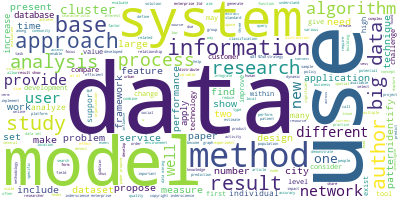

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(data_lemmatized1))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [13]:
full_list = []  # list containing all words of all texts
for elmnt in data_lem_splitted1:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list



prueba = pd.Series(full_list)
prueba = prueba.str.strip()
prueba= prueba.str.replace(" ","_")



val_counts = prueba.value_counts()[:100].sort_values(ascending=False) # make temporary Series to count
val_counts=val_counts.to_frame()
val_counts = val_counts.set_axis(['Frequency'], axis=1, inplace=False)
val_counts.reset_index(level=0, inplace=True)
val_counts = val_counts.rename(columns={'index': 'Word'})
val_counts[:20]

,Word,Frequency
0,data,4955
1,use,2230
2,model,1586
3,method,1124
4,system,1090
5,paper,1088
6,result,1061
7,propose,948
8,study,923
9,information,907


Tratamos de excluir palabras con un alto grado de aparición pero que no aportarian de forma adecuada a la consecución de tópicos, la elección de las palabras esta basada en la frecuencia de aparición, además de un proces de retrocalculo una vez se corrio el modelo y se vieron tópicos poco representativos:

In [14]:

new_stop_word =['one','present','model','method','two','ltd','diferent','number','process','data','use','also','paper', 'user',
                'base','propose','approach','show','provide','make','many','need','various','task','allow','result','author','set','et','al']


def new_stopwords(arg1):
    return ' '.join([word for word in arg1.split() if word not in new_stop_word])

df['Abstract'] = df['Abstract'].apply(new_stopwords)

data_lem_splitted = [r.split() for r in df['Abstract']]

Después de aplicar las `stop_words`, se obtiene el siguiente listado, que contiene palabras mucho más adecuadas y sin valores tan limites. 


In [15]:
full_list = []  # list containing all words of all texts
for elmnt in data_lem_splitted:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list



prueba = pd.Series(full_list)
prueba = prueba.str.strip()
prueba= prueba.str.replace(" ","_")



val_counts = prueba.value_counts()[:100].sort_values(ascending=False) # make temporary Series to count
val_counts=val_counts.to_frame()
val_counts = val_counts.set_axis(['Frequency'], axis=1, inplace=False)
val_counts.reset_index(level=0, inplace=True)
val_counts = val_counts.rename(columns={'index': 'Word'})
val_counts[:20]

,Word,Frequency
0,system,1090
1,study,923
2,information,907
3,analysis,872
4,algorithm,863
5,research,857
6,network,839
7,time,725
8,different,648
9,new,642


### **Diccionario y Matriz Documento - Termino**

Como ingestión para los modelos se hace necesario el uso de una matriz documento término, la cual inicialmente es creada a partir de un diccionario con los datos lematizados.

In [16]:
dictionary = corpora.Dictionary(data_lem_splitted)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in data_lem_splitted]

Se usa la libreria de `gensim` para el cálculo de los tópicos, en este caso como aproximación incial se presenta para 10 tópicos

In [17]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, 
                id2word=dictionary, 
                num_topics=10, 
                chunksize=25, 
                passes=10,
                alpha=0.6,
                eta=0.85,
                iterations=400,
                random_state=200,
                )

Para cada uno de los textos se presenta su tópico dominante, y las palabras que más se ajustan a este. 

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=df['Abstract'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.8413,"information, system, algorithm, database, rese...",mobility fundamental requirement human life si...
1,1,9.0,0.4709,"information, system, algorithm, database, rese...",recent rise political extremism western countr...
2,2,9.0,0.7337,"information, system, algorithm, database, rese...",power press shape informational landscape popu...
3,3,9.0,0.9346,"information, system, algorithm, database, rese...",identify influential node network fundamental ...
4,4,9.0,0.6866,"information, system, algorithm, database, rese...",complement traditional dietary survey costly l...


Con LDA existen 2 scores que brindan la posibilidad de medir el grado de afinidad que tiene el modelo entrenado, así queremos un valor bajo de *Perplexity* y uno alto de *Coherence*

In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lem_splitted, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.538969907875178

Coherence Score:  0.39677118438735437


Entonces, normalmente en la literatura el uso de la coherencia es más aceptado y brinda un acercamiento más claro al *topic modelling*, por esto desarrollamos una función que permita obtener el valor óptimo de tópicos a traves de este score. 

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=3, chunksize=25, random_state=10,passes =8)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Se corre la función que trae como resultado el número de tópicos y su coherencia, este es corrido desde 2 hasta 20 tópicos seleccionados, con pasos de 1 

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=doc_term_matrix, 
                                                        texts=data_lem_splitted,
                                                        start=2, 
                                                        limit=20, 
                                                        step=1)

Esta gráfica representa la variación de la coherencia con el número de tópicos, se elige la que presente el número más alto de coherencia, pero también se verifica con la data

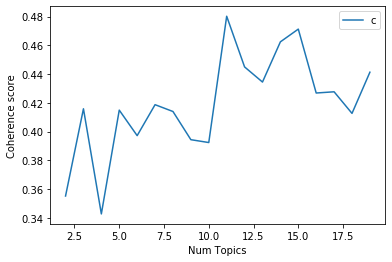

In [22]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

El mejor modelo se muestra a continuación

In [23]:
lista = pd.DataFrame(
    {'model': model_list,
     'coherence': coherence_values})
pd.set_option('display.max_colwidth', None)
print("Mejor Modelo con: ")
lista.iloc[lista['coherence'].idxmax()]

Mejor Modelo con: 


model        LdaModel(num_terms=14027, num_topics=11, decay=0.5, chunksize=25)
coherence                                                             0.480213
Name: 9, dtype: object

Una vista de la gráfica en formato de tabla

In [24]:
lista.sort_values(by=['coherence'], ascending=False).head(5)

,model,coherence
9,"LdaModel(num_terms=14027, num_topics=11, decay=0.5, chunksize=25)",0.480213
13,"LdaModel(num_terms=14027, num_topics=15, decay=0.5, chunksize=25)",0.471261
12,"LdaModel(num_terms=14027, num_topics=14, decay=0.5, chunksize=25)",0.462404
10,"LdaModel(num_terms=14027, num_topics=12, decay=0.5, chunksize=25)",0.444964
17,"LdaModel(num_terms=14027, num_topics=19, decay=0.5, chunksize=25)",0.441288


Se vuelve a correr el módelo individual con la respuesta obtenida para observar la tabla con los topicos dominantes y sus keywords asociadas por documento

In [34]:
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, 
                id2word=dictionary, 
                workers=3, 
                num_topics=11, 
                chunksize=25, 
                random_state=10,
                passes=8,
                decay=0.5)


print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lem_splitted, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.819478630455766

Coherence Score:  0.4773734509294521


Y esta son las keywords de los topicos y el texto correspondiente

In [37]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=df['original'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

Visualizamos los textos que tienen una contribución mucho más fuerte, con el fin de determinar la capacidad del algoritmo de asociarlos, se puede ver una precisión bastante aceptable

In [38]:
df_dominant_topic.sort_values(by=['Topic_Perc_Contrib'], ascending=False)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
58,58,6.0,0.9916,"learn, performance, cloud, framework, machine, application, compute, high, index, problem","Recently, there have been several proposals in the area of geo-distributed big data processing. In this work, we aim to address a limitation of the existing solutions, namely to optimize task allocation across geographically distributed data centers, in a way that both the total traffic and the running time of the whole processing in complex multi-stage flows are targeted. Apart from proposing concrete efficient solutions for this combinatorial problem, we advocate to take a critical stand on the broadly spread claim that transferring distributed data to a single or fewer places is too costly. In our proposal, we judiciously reduce the participation of some data centers in the flow execution, and we show that, in a wide range of settings, this yields significant benefits. We show that a stochastic solution is superior to a fast greedy one, at the expense of optimization time of up to a few minutes. Compared to a state-of-the-art solution, we manage to decrease total traffic by 44% and running time by 37% on average. In several cases, the improvements can reach 1-2 orders of magnitude. Moreover, we provide evidence that simple heuristics are inferior. Our experimental evaluation comprises both extensive simulations and real runs in Spark. © 2019 Elsevier Inc."
66,66,4.0,0.9899,"research, information, science, system, business, service, customer, database, knowledge, scientific","This article attempts to develop a model by integrating interpretive structural modeling (ISM) and quality function deployment (QFD) methodology by establishing the relationship between the Indian retail service quality dimensions and service quality enablers. The integrated approach is employed to translate customers’ requirements/needs into specific service design factors/requirements in the Indian retail context. The retail service quality dimensions are identified using factor analysis and are considered as the customer demands in QFD process. Thirteen retail enablers were identified through an extensive literature survey and expert opinions. The enablers identified for the study were treated as design requirement for employing quality function deployment (QFD) in order to prioritize the design requirements. The results found showed that retail enablers ‘Image of the Store’ and ‘Value Conscious Consumers’ can be emphasized more in a priority basis by the Indian retailers followed by retail enablers ‘Location of store’ and ‘Globalization/Competition’. Copyright © 2019, IGI Global."
120,120,8.0,0.9880,"mining, algorithm, rule, web, query, database, pattern, inderscience, technique, time","With the popularity of knowledge graphs growing rapidly, large amounts of RDF graphs have been released, which raises the need for addressing the challenge of distributed subgraph matching queries. In this paper, we propose an efficient distributed method to answer subgraph matching queries on big RDF graphs using MapReduce. In our method, query graphs are decomposed into a set of stars that utilize the semantic and structural information embedded RDF graphs as heuristics. Two optimization techniques are proposed to further improve the efficiency of our algorithms. One algorithm, called RDF property filtering, filters out invalid input data to reduce intermediate results; the other is to improve the query performance by postponing the Cartesian product operations. The extensive experiments on both synthetic and real-world datasets show that our method outperforms the close competitors S2X and SHARD by an order of magnitude on average. © 2019, The Author(s)."
82,82,8.0,0.9880,"mining, algorithm, rule, web, query, database, pattern, inderscience, technique, time","With the popularity of knowledge graphs growing rapidly, large amounts of RDF graphs have been released, which raises the need for addressi

Miremos las palabras asociadas a cada tópico junto a su peso

In [39]:
lda_model.show_topics(formatted=False, num_topics=11)

[(0,
  [('urban', 0.023256931),
   ('spatial', 0.021803793),
   ('city', 0.019882934),
   ('study', 0.014988249),
   ('area', 0.01205594),
   ('population', 0.008543683),
   ('measure', 0.008070161),
   ('distribution', 0.0072732964),
   ('location', 0.0071574175),
   ('space', 0.007077257)]),
 (1,
  [('social', 0.024854435),
   ('health', 0.015624138),
   ('online', 0.014100034),
   ('medium', 0.01194681),
   ('study', 0.011087895),
   ('event', 0.009505624),
   ('ann', 0.00857555),
   ('human', 0.008425115),
   ('liebert', 0.008263246),
   ('mary', 0.008263246)]),
 (2,
  [('corpus', 0.01821416),
   ('team', 0.013029356),
   ('student', 0.011938207),
   ('variable', 0.010492464),
   ('potentially', 0.010386499),
   ('ground', 0.009983066),
   ('response', 0.008367251),
   ('age', 0.008019962),
   ('radiation', 0.007879016),
   ('walk', 0.0078423545)]),
 (3,
  [('page', 0.05998858),
   ('workflow', 0.027955227),
   ('word', 0.026753087),
   ('satisfaction', 0.015990093),
   ('iwum', 0.

Las siguientes gráficas permiten visualizar de forma clara las palabras asociadas a cada tópico, sin embargo es de suma importancia anotar que se muestran tan solo 10, porque el parametro de show_topics de LDA solo permite como máximo 10

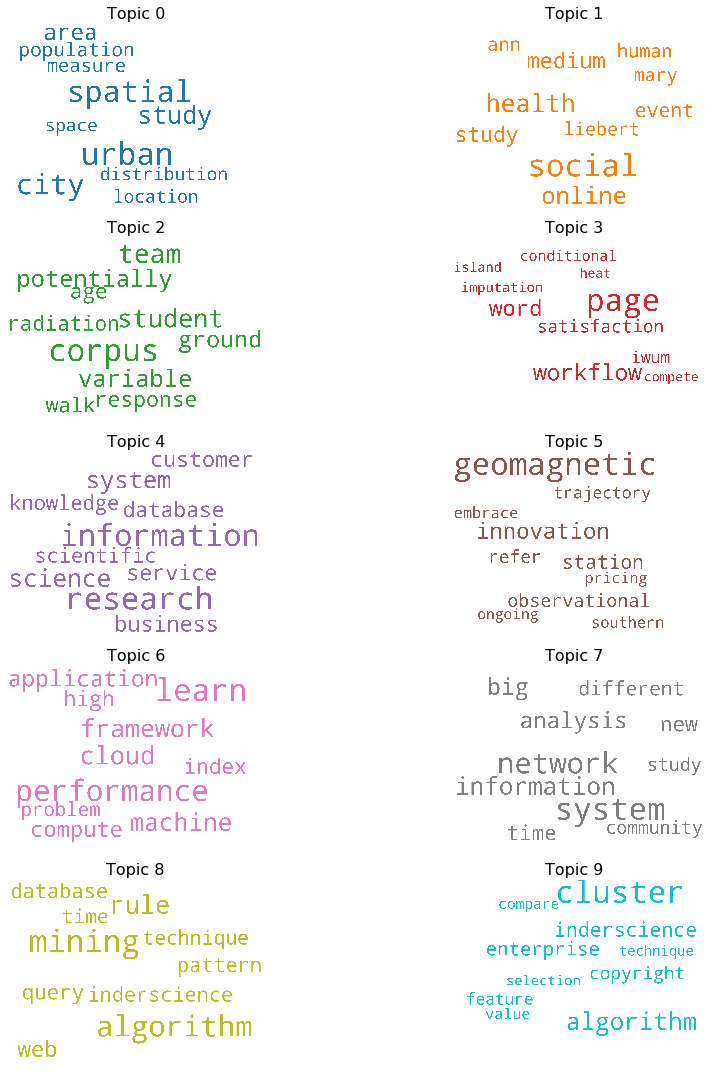

In [40]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=100)


fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Acá se visuala la repetición de las palabras del tópico en el texto (en el eje izquierdo), y el peso que tiene en ese tópico (en el eje derecho)

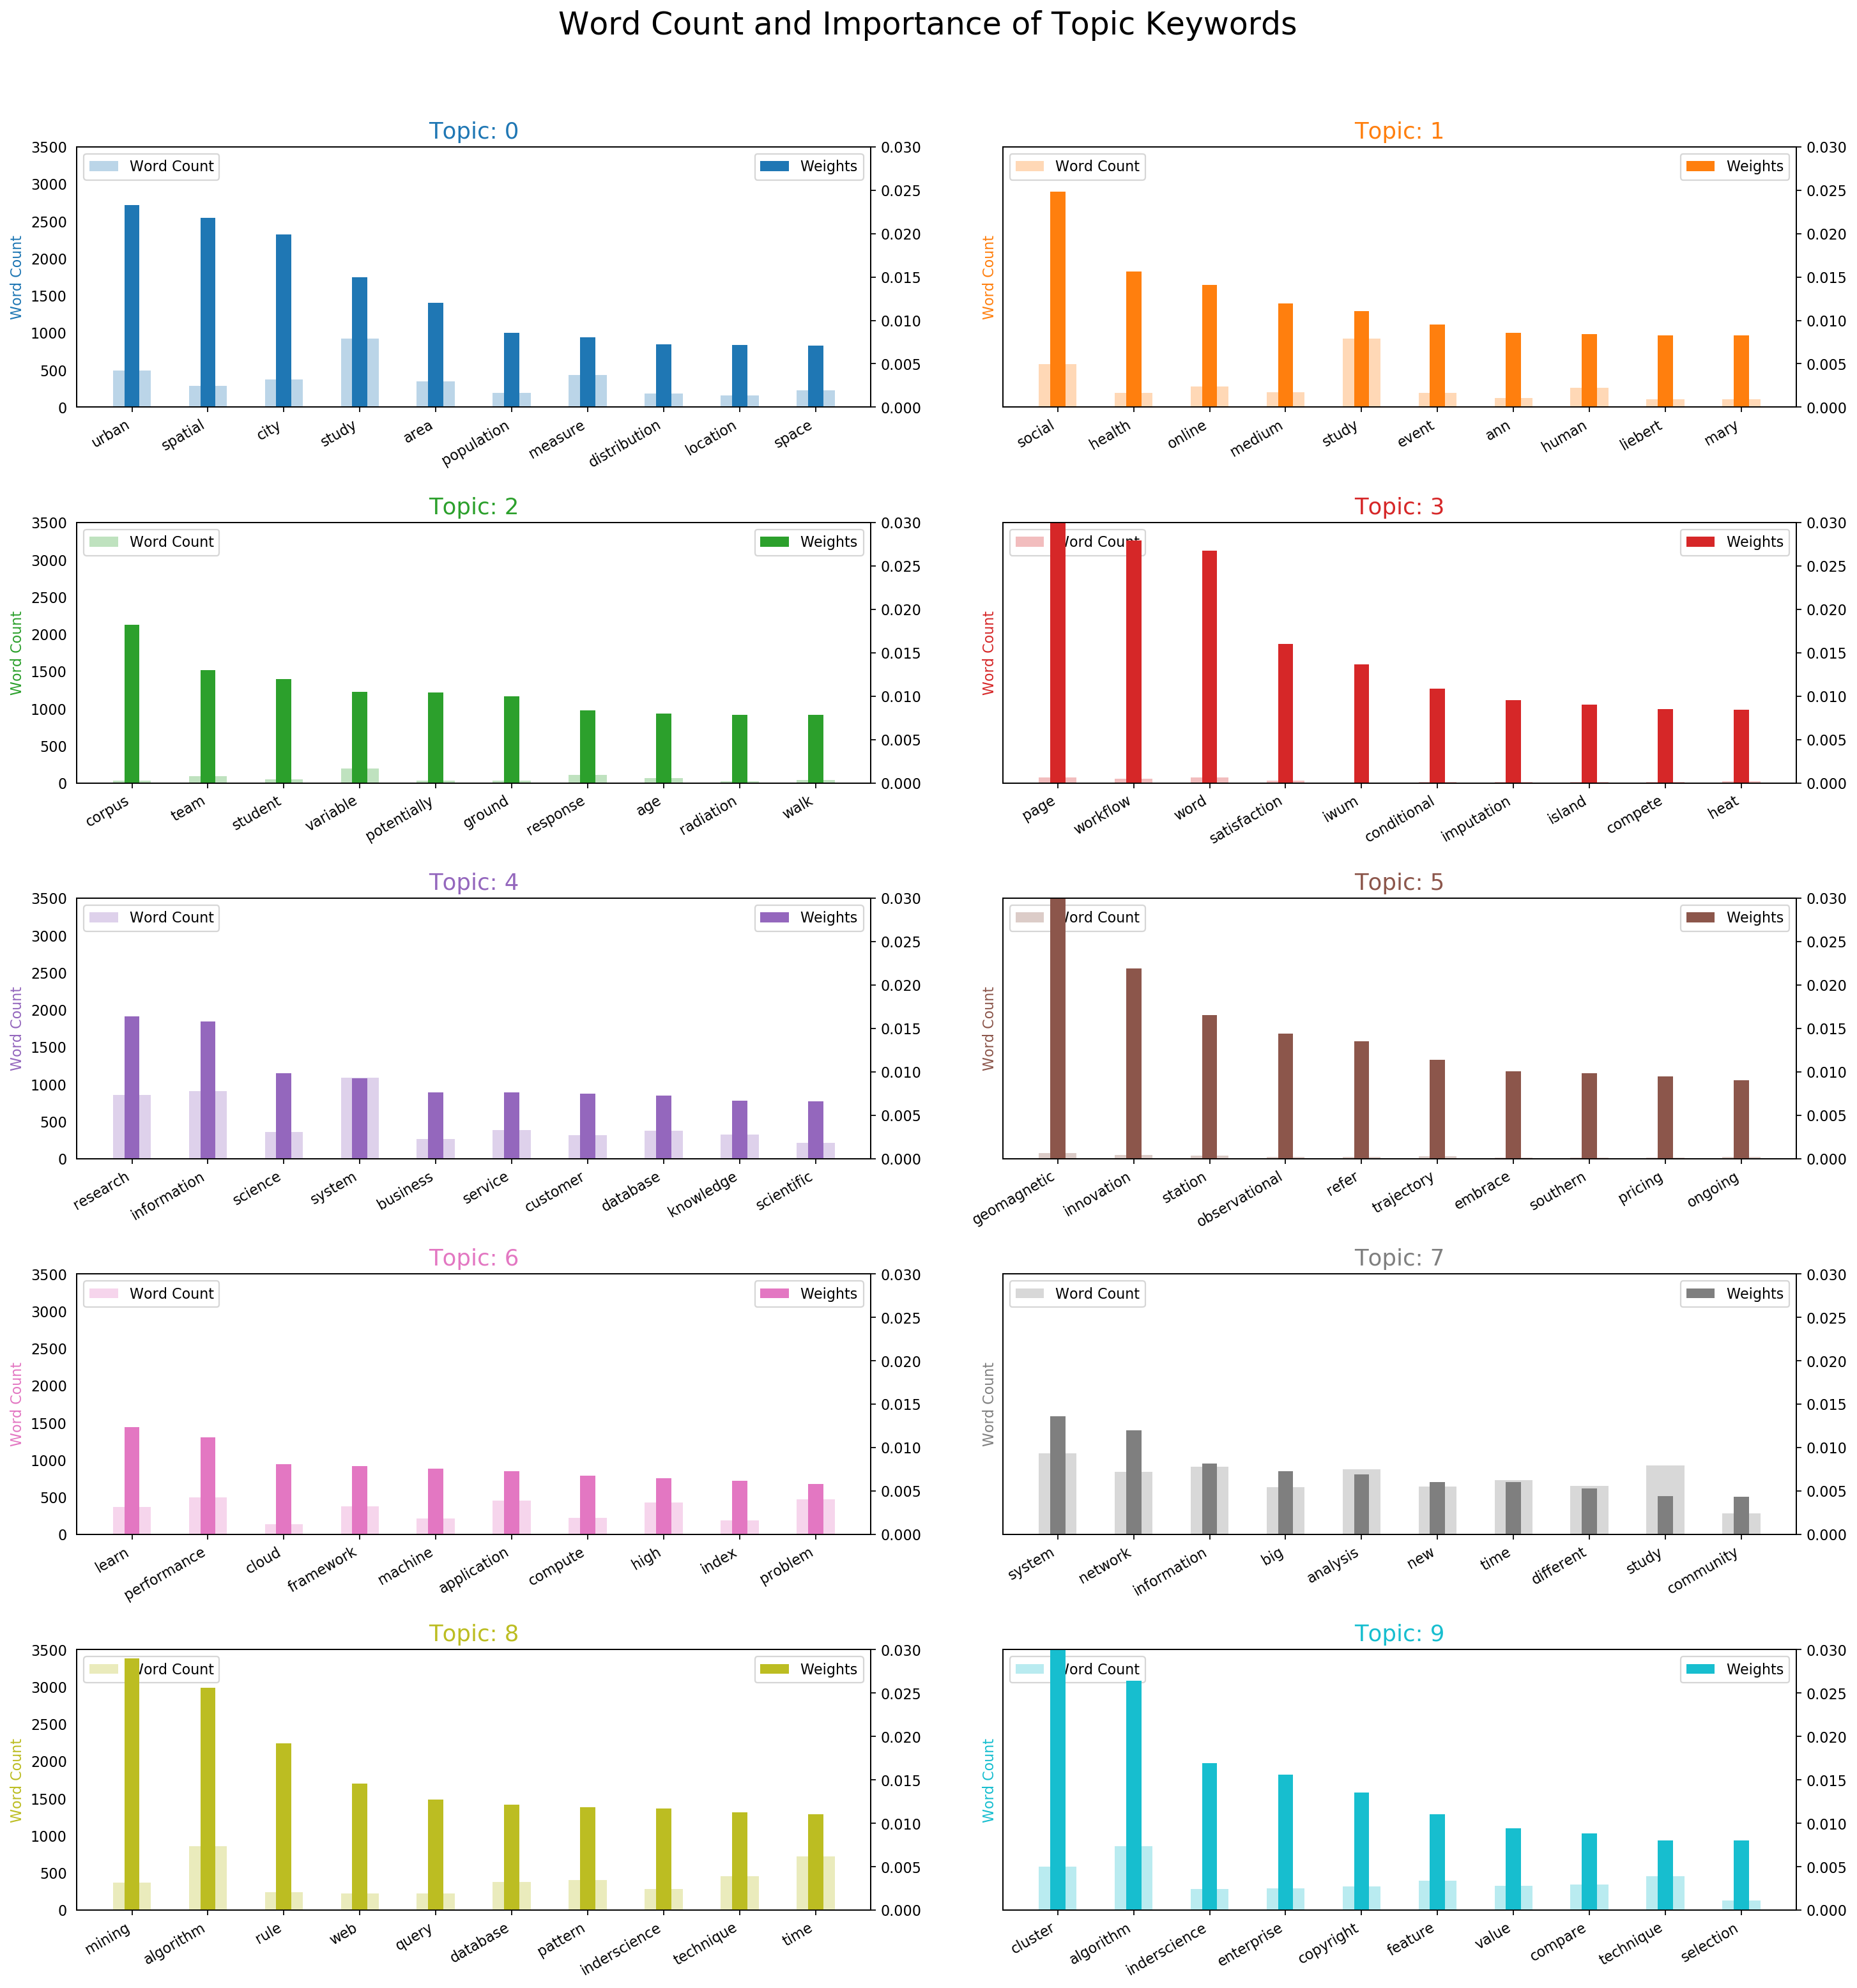

In [41]:
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_topics=14)
data_flat = [w for w_list in data_lem_splitted for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,18), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.set_size_inches(18.5, 18.5)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### **Visualización de los tópicos con `pyLDAvis`**

In [57]:
import pyLDAvis
#from pyLDAvis import gensim
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.209582  0.085930       1        1  33.865673
4     -0.189808  0.092796       2        1  18.844186
8     -0.164293 -0.185883       3        1   9.599683
6     -0.130121 -0.096638       4        1   9.549849
0     -0.049753  0.201585       5        1   9.481045
9     -0.125936 -0.198567       6        1   7.701121
1     -0.027870  0.171666       7        1   7.665912
2      0.191497  0.022743       8        1   1.804498
10     0.238443 -0.031512       9        1   0.621505
5      0.238577 -0.031818      10        1   0.498108
3      0.228847 -0.030302      11        1   0.368420, topic_info=           Term        Freq       Total Category  logprob  loglift
288     cluster  654.000000  654.000000  Default  30.0000  30.0000
1122  algorithm  871.000000  871.000000  Default  29.0000  29.0000
412      mining  501.000000  501.000000  Default  28.0000  28.0000
55       social  527.000000  527.000000  Default  27.0000  27.0000
709       urban  388.000000  388.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1634     aspect    2.769518  115.473201  Topic11  -5.4535   1.8733
2101    surface    1.281963   28.760675  Topic11  -6.2238   2.4931
1730  frequency    1.506191   65.050059  Topic11  -6.0626   1.8381
1734    product    1.316271  189.380370  Topic11  -6.1974   0.6347
2024        web    0.947486  325.815283  Topic11  -6.5262  -0.2366

[645 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3050     10  0.661017     1980s
5759      4  0.983706     1990s
1493      6  0.975693      2001
8223      2  0.990192      2005
4420      2  0.215000      2006
...     ...       ...       ...
188       8  0.002644      work
2938      7  0.974254    worker
1054      2  0.349822  workflow
1054     11  0.629680  workflow
757       5  0.978880      zone

[1250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 9, 7, 1, 10, 2, 3, 11, 6, 4])